In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("covid").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
sc = spark.sparkContext

In [ ]:
from pyspark.sql.types import StringType,DoubleType,IntegerType, TimestampType
from pyspark.sql.functions import to_timestamp, regexp_replace, when

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [ ]:
url_base_dataset = "/content/drive/My Drive/st0263-p3-grupo2/2020-11-21.csv"
data = spark.read.csv(url_base_dataset, inferSchema=True, header=True, sep=";")

In [ ]:
data.printSchema()

root
 |-- fecha_hoy_casos: string (nullable = true)
 |-- Caso: integer (nullable = true)
 |-- Fecha Not: string (nullable = true)
 |-- Departamento: integer (nullable = true)
 |-- Departamento_nom: string (nullable = true)
 |-- Ciudad_municipio: integer (nullable = true)
 |-- Ciudad_municipio_nom: string (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- unidad_medida: integer (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Fuente_tipo_contagio: string (nullable = true)
 |-- Ubicacion: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Pais_viajo_1_cod: string (nullable = true)
 |-- Pais_viajo_1_nom: string (nullable = true)
 |-- Recuperado: string (nullable = true)
 |-- Fecha_inicio_sintomas: string (nullable = true)
 |-- Fecha_muerte: string (nullable = true)
 |-- Fecha_diagnostico: string (nullable = true)
 |-- Fecha_recuperado: string (nullable = true)
 |-- Tipo_recuperacion: string (nullable = true)
 |-- per_etn_: integer (nullable = true)
 |--

In [ ]:
data.show(5)

+-----------------+----+----------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-----------------+-----------------+-----------------+--------+----------+
|  fecha_hoy_casos|Caso|       Fecha Not|Departamento|Departamento_nom|Ciudad_municipio|Ciudad_municipio_nom|Edad|unidad_medida|Sexo|Fuente_tipo_contagio|Ubicacion|Estado|Pais_viajo_1_cod|Pais_viajo_1_nom|Recuperado|Fecha_inicio_sintomas|Fecha_muerte|Fecha_diagnostico| Fecha_recuperado|Tipo_recuperacion|per_etn_|nom_grupo_|
+-----------------+----+----------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-----------------+-----------------+-----------------+--------+----------+
| 6/3/2020 0:00:00|   

In [ ]:
data['Fecha Not']

Column<b'Fecha Not'>

In [ ]:

_data = _data.withColumn("Fecha Not a", to_timestamp("Fecha Not", "dd/MM/yyyy HH:mm:ss"))
_data.show(5)

+-----------------+----+----------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-----------------+-----------------+-----------------+--------+----------+-------------------+
|  fecha_hoy_casos|Caso|       Fecha Not|Departamento|Departamento_nom|Ciudad_municipio|Ciudad_municipio_nom|Edad|unidad_medida|Sexo|Fuente_tipo_contagio|Ubicacion|Estado|Pais_viajo_1_cod|Pais_viajo_1_nom|Recuperado|Fecha_inicio_sintomas|Fecha_muerte|Fecha_diagnostico| Fecha_recuperado|Tipo_recuperacion|per_etn_|nom_grupo_|        Fecha Not a|
+-----------------+----+----------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-----------------+-----------------+-----------------+---

In [ ]:
#Cambia datos de fecha a timestamp
data = data.withColumn("Fecha Not", to_timestamp("Fecha Not", "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("fecha_hoy_casos", to_timestamp("fecha_hoy_casos", "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("Fecha_inicio_sintomas", to_timestamp("Fecha_inicio_sintomas", "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("Fecha_diagnostico", to_timestamp("Fecha_diagnostico", "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("Fecha_recuperado", to_timestamp("Fecha_recuperado", "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("Fecha_muerte", to_timestamp("Fecha_muerte", "dd/MM/yyyy HH:mm:ss"))

In [ ]:
print((data.count(), len(data.columns)))

(1240493, 23)


In [ ]:
data.show(5)

+-------------------+----+-------------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-------------------+-------------------+-----------------+--------+----------+
|    fecha_hoy_casos|Caso|          Fecha Not|Departamento|Departamento_nom|Ciudad_municipio|Ciudad_municipio_nom|Edad|unidad_medida|Sexo|Fuente_tipo_contagio|Ubicacion|Estado|Pais_viajo_1_cod|Pais_viajo_1_nom|Recuperado|Fecha_inicio_sintomas|Fecha_muerte|  Fecha_diagnostico|   Fecha_recuperado|Tipo_recuperacion|per_etn_|nom_grupo_|
+-------------------+----+-------------------+------------+----------------+----------------+--------------------+----+-------------+----+--------------------+---------+------+----------------+----------------+----------+---------------------+------------+-------------------+-------------------+-----------------+--------+-------

In [ ]:
#Inspección
data.select('Departamento_nom').distinct().show()
data.select('Ciudad_municipio_nom').distinct().show()
data.select('unidad_medida').distinct().show()
data.select('Edad').distinct().show()
data.select('Fuente_tipo_contagio').distinct().show()
data.select('Ubicacion').distinct().show()
data.select('Estado').distinct().show()
data.select('Pais_viajo_1_nom').distinct().show()
data.select('Recuperado').distinct().show()
data.select('Tipo_recuperacion').distinct().show()

+----------------+
|Departamento_nom|
+----------------+
|       SANTANDER|
|          VAUPES|
|         CAQUETA|
|        CASANARE|
|            META|
|          NARI�O|
|        AMAZONAS|
|       CARTAGENA|
|        GUAVIARE|
|           CAUCA|
|         VICHADA|
| NORTE SANTANDER|
|       ANTIOQUIA|
|         QUINDIO|
|           CHOCO|
|          CALDAS|
|          BOYACA|
|    CUNDINAMARCA|
|      SAN ANDRES|
|          TOLIMA|
+----------------+
only showing top 20 rows

+--------------------+
|Ciudad_municipio_nom|
+--------------------+
|             ARMENIA|
|              PAICOL|
|           SAN PABLO|
|             MAHATES|
|            CHIQUIZA|
|       PUERTO TEJADA|
|            NORCASIA|
|             YOLOMBO|
|            EL ROSAL|
|        ANSERMANUEVO|
|             GUAVATA|
|             TIBACUY|
|          FUSAGASUGA|
|             ANSERMA|
|             GARAGOA|
|          CONVENCION|
|           CHAPARRAL|
|               UBALA|
|              PELAYA|
|          C

In [ ]:
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "Relacioando", "relacionado").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "Relacionado", "relacionado").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "RELACIONADO", "relacionado").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "EN ESTUDIO", "en estudio").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "En Estudio", "en estudio").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "En estudio", "en estudio").otherwise(data["Fuente_tipo_contagio"]))
data = data.withColumn("Fuente_tipo_contagio", when(data["Fuente_tipo_contagio"] == "En estudio       ...", "en estudio").otherwise(data["Fuente_tipo_contagio"]))

data = data.withColumn("Ubicacion", when(data["Ubicacion"] == "CASA", "casa").otherwise(data["Ubicacion"]))
data = data.withColumn("Ubicacion", when(data["Ubicacion"] == "Casa", "casa").otherwise(data["Ubicacion"]))
data = data.withColumn("Ubicacion", when(data["Ubicacion"] == "Casa             ...", "casa").otherwise(data["Ubicacion"]))
data = data.withColumn("Ubicacion", when(data["Ubicacion"] == "Hospital ", "Hospital").otherwise(data["Ubicacion"]))

data = data.withColumn("Estado", when(data["Estado"] == "Moderado", "moderado").otherwise(data["Estado"]))
data = data.withColumn("Estado", when(data["Estado"] == "Leve", "leve").otherwise(data["Estado"]))
data = data.withColumn("Estado", when(data["Estado"] == "LEVE", "leve").otherwise(data["Estado"]))
data = data.withColumn("Estado", when(data["Estado"] == "Leve             ...", "leve").otherwise(data["Estado"]))

data = data.withColumn("Recuperado", when(data["Recuperado"] == "Fallecido", "fallecido").otherwise(data["Recuperado"]))

In [ ]:
# Inspección 2
#Inspección
data.select('Ubicacion').distinct().show()
data.select('Estado').distinct().show()
data.select('Recuperado').distinct().show()

+--------------------+
|           Ubicacion|
+--------------------+
|        Hospital UCI|
|           Fallecido|
|Casa             ...|
|                 N/A|
|            Hospital|
|               Casa |
|                casa|
+--------------------+

+--------------------+
|              Estado|
+--------------------+
|           Fallecido|
|            moderado|
|Leve             ...|
|                 N/A|
|                leve|
|               Grave|
+--------------------+

+----------+
|Recuperado|
+----------+
|       N/A|
| fallecido|
|Recuperado|
|    Activo|
+----------+



## Dias entre notificación y diagnostico

In [ ]:
data = data.withColumn("Dias entre notificacion y diagnostico",
                       (data["Fecha_diagnostico"].cast("long") - data["Fecha Not"].cast("long")) / 86400)


## Dias entre diagnostico y recuperación

In [ ]:
data = data.withColumn("Dias entre diagnostico y recuperacion",
                       (data["Fecha_recuperado"].cast("long") - data["Fecha_diagnostico"].cast("long")) / 86400)

In [ ]:
data.select("Fecha Not", "Fecha_diagnostico", "Dias entre notificacion y diagnostico").show(5)
data.select("Fecha_recuperado", "Fecha_diagnostico", "Dias entre diagnostico y recuperacion").show(5)


+-------------------+-------------------+-------------------------------------+
|          Fecha Not|  Fecha_diagnostico|Dias entre notificacion y diagnostico|
+-------------------+-------------------+-------------------------------------+
|2020-03-02 00:00:00|2020-03-06 00:00:00|                                  4.0|
|2020-03-06 00:00:00|2020-03-09 00:00:00|                                  3.0|
|2020-03-07 00:00:00|2020-03-09 00:00:00|                                  2.0|
|2020-03-09 00:00:00|2020-03-11 00:00:00|                                  2.0|
|2020-03-09 00:00:00|2020-03-11 00:00:00|                                  2.0|
+-------------------+-------------------+-------------------------------------+
only showing top 5 rows

+-------------------+-------------------+-------------------------------------+
|   Fecha_recuperado|  Fecha_diagnostico|Dias entre diagnostico y recuperacion|
+-------------------+-------------------+-------------------------------------+
|2020-03-13 00:

In [ ]:
data = data.withColumn("menores de 18", data["Edad"] < 18)
data.select("menores de 18", "Edad").filter(data["menores de 18"]).filter(data["unidad_medida"] == 1).show(10)
data.select("menores de 18", "Edad").filter(data["menores de 18"]).filter(data["unidad_medida"] == 1).count()

+-------------+----+
|menores de 18|Edad|
+-------------+----+
|         true|   9|
|         true|  16|
|         true|  17|
|         true|  15|
|         true|   9|
|         true|  15|
|         true|   3|
|         true|   9|
|         true|  16|
|         true|  16|
+-------------+----+
only showing top 10 rows



88548

## Personas en estado grave o fallecido

In [ ]:
grave_fallecido = data.filter((data["Estado"] == "Grave") | (data["Estado"] == "Fallecido")).select(
    "Edad", "Ubicacion", "Estado", "Pais_viajo_1_nom", "Estado", "Sexo", "Tipo_recuperacion", "Departamento_nom", "Fecha Not",
    "Fecha_inicio_sintomas", "Fecha_muerte", "Fecha_diagnostico", "Fecha_recuperado"
).orderBy("Dias entre diagnostico y recuperacion")
grave_fallecido.show(5)
grave_fallecido.count()

+----+---------+---------+----------------+---------+----+-----------------+----------------+-------------------+---------------------+-------------------+-------------------+----------------+
|Edad|Ubicacion|   Estado|Pais_viajo_1_nom|   Estado|Sexo|Tipo_recuperacion|Departamento_nom|          Fecha Not|Fecha_inicio_sintomas|       Fecha_muerte|  Fecha_diagnostico|Fecha_recuperado|
+----+---------+---------+----------------+---------+----+-----------------+----------------+-------------------+---------------------+-------------------+-------------------+----------------+
|  76|Fallecido|Fallecido|            null|Fallecido|   F|             null|          BOGOTA|2020-08-31 00:00:00|  2020-08-31 00:00:00|2020-09-14 00:00:00|2020-08-31 00:00:00|            null|
|  77|Fallecido|Fallecido|            null|Fallecido|   M|             null|          BOGOTA|2020-08-31 00:00:00|  2020-08-31 00:00:00|2020-09-20 00:00:00|2020-09-01 00:00:00|            null|
|  66|Fallecido|Fallecido|         

37705

In [ ]:
# Personas en estado grave o fallecido menores de 18
grave_fallecido_lt_18 = data.filter((data["Estado"] == "Grave") | (data["Estado"] == "Fallecido")).filter(data["Edad"] < 18).filter(data["unidad_medida"] == 1).select(
    "Edad", "Ubicacion", "Estado", "Pais_viajo_1_nom", "Estado", "Sexo", "Tipo_recuperacion", "Departamento_nom", "Fecha Not",
    "Fecha_inicio_sintomas", "Fecha_muerte", "Fecha_diagnostico", "Fecha_recuperado"
).orderBy("Dias entre diagnostico y recuperacion")
grave_fallecido_lt_18.show(5)
grave_fallecido_lt_18.count()

+----+------------+---------+----------------+---------+----+-----------------+----------------+-------------------+---------------------+-------------------+-------------------+----------------+
|Edad|   Ubicacion|   Estado|Pais_viajo_1_nom|   Estado|Sexo|Tipo_recuperacion|Departamento_nom|          Fecha Not|Fecha_inicio_sintomas|       Fecha_muerte|  Fecha_diagnostico|Fecha_recuperado|
+----+------------+---------+----------------+---------+----+-----------------+----------------+-------------------+---------------------+-------------------+-------------------+----------------+
|   6|   Fallecido|Fallecido|            null|Fallecido|   M|             null|           HUILA|2020-08-25 00:00:00|  2020-08-22 00:00:00|2020-09-14 00:00:00|2020-09-05 00:00:00|            null|
|   4|Hospital UCI|    Grave|            null|    Grave|   F|             null|          BOGOTA|2020-09-04 00:00:00|  2020-09-01 00:00:00|               null|2020-09-05 00:00:00|            null|
|   7|Hospital UCI| 

114

## Paises a los que mas se realizan viajes

In [ ]:
paises = data.groupBy("Pais_viajo_1_cod", "Pais_viajo_1_nom").count().orderBy('count', ascending=False)
paises.show(50)

+----------------+--------------------+-------+
|Pais_viajo_1_cod|    Pais_viajo_1_nom|  count|
+----------------+--------------------+-------+
|            null|                null|1239545|
|             724|              ESPA�A|    258|
|             840|      ESTADOS UNIDOS|    212|
|             218|             ECUADOR|     64|
|             484|              M�XICO|     52|
|              76|              BRASIL|     50|
|             591|              PANAMA|     34|
|             792|             TURQU�A|     27|
|             152|               CHILE|     20|
|             250|             FRANCIA|     19|
|             604|                PERU|     18|
|             862|           VENEZUELA|     18|
|             388|             JAMAICA|     16|
|             826|REINO UNIDO DE GR...|     14|
|             630|         PUERTO RICO|     13|
|             380|              ITALIA|     11|
|             276|            ALEMANIA|     11|
|             818|              EGIPTO| 

# Departamentos con mas contagios

In [ ]:
departamentos = data.groupBy("Departamento", "Departamento_nom").count().orderBy('count', ascending=False)
departamentos.show(50)

+------------+----------------+------+
|Departamento|Departamento_nom| count|
+------------+----------------+------+
|          11|          BOGOTA|356618|
|           5|       ANTIOQUIA|201521|
|          76|           VALLE|101112|
|          68|       SANTANDER| 49806|
|          25|    CUNDINAMARCA| 49051|
|        8001|    BARRANQUILLA| 43569|
|           8|       ATLANTICO| 32214|
|       13001|       CARTAGENA| 28891|
|          41|           HUILA| 28551|
|          20|           CESAR| 28540|
|          23|         CORDOBA| 27875|
|          50|            META| 26606|
|          73|          TOLIMA| 26412|
|          54| NORTE SANTANDER| 26006|
|          52|          NARI�O| 24341|
|          17|          CALDAS| 22116|
|          66|       RISARALDA| 21525|
|          15|          BOYACA| 19695|
|          70|           SUCRE| 16262|
|          63|         QUINDIO| 15261|
|          19|           CAUCA| 15086|
|          18|         CAQUETA| 12784|
|       47001|  STA MARTA

# Municipios con mayor contagio

In [ ]:
municipios = data.groupBy("Ciudad_municipio", "Ciudad_municipio_nom").count().orderBy('count', ascending=False)
municipios.show(50)

+----------------+--------------------+------+
|Ciudad_municipio|Ciudad_municipio_nom| count|
+----------------+--------------------+------+
|           11001|              BOGOTA|356618|
|            5001|            MEDELLIN|115666|
|           76001|                CALI| 73958|
|            8001|        BARRANQUILLA| 43569|
|           13001|           CARTAGENA| 28891|
|           68001|         BUCARAMANGA| 21191|
|           50001|       VILLAVICENCIO| 19648|
|           73001|              IBAGUE| 19599|
|           41001|               NEIVA| 18844|
|           20001|          VALLEDUPAR| 18826|
|            5088|               BELLO| 17779|
|           54001|              CUCUTA| 17052|
|           23001|            MONTERIA| 16615|
|           17001|           MANIZALES| 15609|
|            8758|             SOLEDAD| 15507|
|           66001|             PEREIRA| 14388|
|           25754|              SOACHA| 13785|
|           52001|               PASTO| 13502|
|           4

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
%matplotlib inline
configure_plotly_browser_state()

In [ ]:
import IPython
IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode, plot
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import plotly.graph_objects as go
df_bar_colombia = departamentos.orderBy("count").toPandas()
fig = go.Figure(go.Bar(
            x=df_bar_colombia["count"],
            y=df_bar_colombia["Departamento_nom"],
            text=df_bar_colombia["count"],
            orientation='h'))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(height=800,
                  title = 'Número de casos por departamento o distrito',  
                  xaxis_title="Número de casos",
                  yaxis_title="Departamentos o distritos",    
                  title_x=0.5,  
)
fig.show()

In [ ]:
from pyspark.sql.functions import udf
age_range = udf(lambda age: '<18' if age < 18 else 
                       '18-25' if 18 <= age < 25 else
                       '25-40' if 25 <= age < 40 else
                       '40-65' if 40 <= age < 65 else
                       '65+' if   age >=65 else '')

data = data.withColumn('Rango edad', age_range(data["Edad"]))
data_edad_range = data.groupBy("Rango edad").count().orderBy("count", ascending=True)
data_edad_range.show()

+----------+------+
|Rango edad| count|
+----------+------+
|       <18| 93588|
|       65+|128893|
|     18-25|142515|
|     40-65|427197|
|     25-40|448300|
+----------+------+



# PIE casos positivos por edad

In [ ]:
import plotly.express as px
df_pie = data_edad_range.toPandas()
fig = px.pie(df_pie, values='count', names='Rango edad',
             hover_data=['count'], labels={'count':'Casos positivos'})
fig.update_layout(title = 'Casos positivos en Colombia por edad',    
                  title_x=0.5,  
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## Tipos de contagio

In [ ]:
import seaborn as sns

tipo_contagio = data.groupBy("Fuente_tipo_contagio").count()
tipo_contagio.show()
sns.barplot(x="Fuente_tipo_contagio", y="count", data=tipo_contagio.toPandas())

+--------------------+-------+
|Fuente_tipo_contagio|  count|
+--------------------+-------+
|           Importado|    916|
|         relacionado| 119624|
|          en estudio|1108183|
|         En estudio |  11768|
|         EN ESTUDIO |      1|
|En estudio       ...|      1|
+--------------------+-------+



# Numero de casos en el tiempo

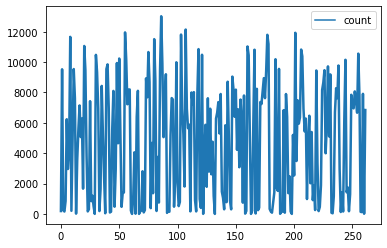

In [ ]:
casos_confir_tiempo = data.groupBy("Fecha Not").count()

sns.lineplot(data=casos_confir_tiempo.toPandas(), palette="tab10", linewidth=2.5)

In [ ]:
write_uri="/content/drive/My Drive/st0263-p3-grupo2/"
data.coalesce(1).write.format("csv").option("header","true").save(write_uri+'/colombia')